# To do:

 - Both
     - Figure out how to signal injuries
 - Mins
     - Work on those cases where role players get an increase in playtime
     - Create foul trouble signal feature
     - Work with Szn_Wins and OppSzn_Wins

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import duckdb
import warnings
import os

import xgboost as xgb
from xgboost import XGBRegressor
from scipy.stats import randint, uniform

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import joblib
import warnings
from datetime import datetime, timedelta

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

categories = ['PTS', 'AST', 'REB', 'PR', 'PA', 'RA', 'PRA', 'TPM', 'STL', 'BLK', 'STL_BLK']
con = duckdb.connect(database=":memory:")

cwd = os.path.abspath(os.getcwd()).replace("\\", "/")
if cwd.startswith("C:/Users/Rodolfo/"):
    RUN_LOCATION = "local"
else:
    RUN_LOCATION = "cloud"
time_offset = {"local": 3, "cloud": -5}
now = str((datetime.now() + timedelta(hours=time_offset[RUN_LOCATION]) + timedelta(hours=-3)).date())
print(f"Today's date:", now)

tgt_stat = "PRA"
print('Target Stat:', tgt_stat)

Today's date: 2026-01-05
Target Stat: PRA


In [2]:
%run ./common_utils.ipynb

# ML Functions

In [3]:
def feature_importance(model, all_features):
    # Get gain importance
    importance = model.get_score(importance_type='gain')
    
    # Fill in 0 for missing features
    df_importance = pd.DataFrame({
        'feature': all_features,
        'importance': [importance.get(f, 0) for f in all_features]
    }).sort_values(by='importance', ascending=False).reset_index(drop=True)
    
    df_importance['pct'] = df_importance.importance.cumsum() / df_importance.importance.sum()
    if df_importance.shape[0] >= 50:
        with pd.option_context('display.max_rows', None):
            display(df_importance)
    else:
        display(df_importance)
    
    xgb.plot_importance(model)
    plt.show()

In [4]:
def create_baseline_model(df, pred_col, DFS):
    
    train_df, val_df, test_df = DFS

    if pred_col == 'MP':
        print('Minutes Model')
        feature_cols = [
            'MP_lst_gm',
            'MP_last_5_avg',
            'MP_last_10_avg',
            'starter', 'bench', 'reserve'
        ]
    else:
        print(f'{pred_col} Stats Model')
        feature_cols = [
            'MP_lst_gm',
            'MP_last_5_avg',
            'MP_last_10_avg',
            f'{pred_col}_last_3_avg', f'{pred_col}_last_5_avg', f'{pred_col}_last_10_avg',
            f'Def_{pred_col}', f'Def_L5_{pred_col}'
        ]
    
    print('Train:', len(train_df), '/ Validation:', len(val_df), '/ Test:', len(test_df))
    
    X_train, y_train = train_df[feature_cols], train_df[pred_col]
    X_val,   y_val   = val_df[feature_cols],   val_df[pred_col]
    X_test,  y_test  = test_df[feature_cols],  test_df[pred_col]

    # Convert to DMatrix (XGBoost internal format)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval   = xgb.DMatrix(X_val, label=y_val)
    dtest  = xgb.DMatrix(X_test, label=y_test)

    params = {
        "objective": "reg:squarederror",
        "max_depth": 5,
        "learning_rate": 0.05,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "seed": 42
    }

    # Train using native XGBoost API with early stopping
    evals = [(dtrain, "train"), (dval, "val")]
    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=500,
        evals=evals,
        early_stopping_rounds=50,
        verbose_eval=False
    )

    # Predict on test set
    preds = bst.predict(dtest)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R²:", r2)
    
    return bst

In [5]:
def hyperparam_tuning(DFS, pred_col, n_iter=20, early_stopping_rounds=50):
    """
    Hyperparameter tuning using native XGBoost API and DMatrix,
    with early stopping support (compatible with XGBoost 3.1.2)
    """

    train_df, val_df, test_df = DFS
    feature_cols = [col for col in train_df.columns if col not in ['Date', pred_col]]
    X_train, y_train = train_df[feature_cols], train_df[pred_col]
    X_val,   y_val   = val_df[feature_cols],   val_df[pred_col]
    X_test,  y_test  = test_df[feature_cols],  test_df[pred_col]

    # Convert datasets to DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval   = xgb.DMatrix(X_val, label=y_val)
    dtest  = xgb.DMatrix(X_test, label=y_test)

    # Hyperparameter search space
    param_dist = {
        "n_estimators": randint(300, 1500),
        "learning_rate": uniform(0.01, 0.05),
        "max_depth": randint(3, 6),
        "min_child_weight": randint(1, 8),
        "subsample": uniform(0.7, 0.3),
        "colsample_bytree": uniform(0.7, 0.3),
        "gamma": uniform(0, 2),
        "reg_lambda": uniform(0, 5),
        "reg_alpha": uniform(0, 2)
    }

    # Sample n_iter random parameter combinations
    param_list = []
    for _ in range(n_iter):
        sample = {k: (v.rvs() if hasattr(v, "rvs") else v) for k, v in param_dist.items()}
        sample['n_estimators'] = int(sample['n_estimators'])
        sample['max_depth'] = int(sample['max_depth'])
        sample['min_child_weight'] = int(sample['min_child_weight'])
        param_list.append(sample)

    best_mae = float('inf')
    best_params = None
    best_bst = None

    # Manual hyperparameter search
    for i, params in enumerate(param_list):
        print(f"\nTrial {i+1}/{n_iter}: {params}")
        num_boost_round = params.pop('n_estimators')
        params.update({
            "objective": "reg:squarederror",
            "tree_method": "hist",
            "device": "cuda",
            "seed": 42
        })
        evals = [(dtrain, 'train'), (dval, 'val')]
        bst = xgb.train(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=early_stopping_rounds,
            verbose_eval=False
        )
        # Predict on validation set to compute MAE
        val_preds = bst.predict(dval, iteration_range=(0, bst.best_iteration))
        mae = mean_absolute_error(y_val, val_preds)
        print(f"Validation MAE: {mae:.4f}")
        if mae < best_mae:
            best_mae = mae
            best_params = params.copy()
            best_bst = bst

    print("\nBest validation MAE:", best_mae)
    print("Best parameters:", best_params)

    # Predict on test set using best model
    preds = best_bst.predict(dtest, iteration_range=(0, best_bst.best_iteration))
    test_df[pred_col] = y_test
    test_df[f'{pred_col}_preds'] = preds
    test_df['Team'] = team_encoder.inverse_transform(test_df["Team"])
    test_df['Opp'] = team_encoder.inverse_transform(test_df["Opp"])
    test_df['Player'] = player_encoder.inverse_transform(test_df["Player"])
    test_df['Pos'] = position_encoder.inverse_transform(test_df["Pos"])
    analyze_df = test_df[['Date', 'Team', 'Player', 'Pos', 'Opp', pred_col, f'{pred_col}_preds']]
    print("\nTest Metrics:")
    print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))
    print("MAE:", mean_absolute_error(y_test, preds))
    print("R²:", r2_score(y_test, preds))

    return best_bst, preds, y_test, analyze_df

### Create Base df

In [6]:
df = pd.DataFrame()
df2 = pd.DataFrame()
df3 = pd.DataFrame()
df4 = pd.DataFrame()
for i in [2021, 2022, 2023, 2024, 2025]:
    df_actuals = pd.read_csv(f"../tables/{i}/parlay_stats.csv")
    df_actuals['Season'] = i
    df = pd.concat([df, df_actuals])

    df_schd = pd.read_csv(f"../tables/{i}/nba_schedule.csv")
    df_schd['Season'] = i
    df2 = pd.concat([df2, df_schd])
    
    df_gms = pd.read_csv(f"../tables/{i}/season_gamelogs.csv")
    df_gms['Season'] = i
    df3 = pd.concat([df3, df_gms])
    
    df_inj = pd.read_csv(f"../tables/{i}/injuries.csv")
    df_inj['Season'] = i
    df4 = pd.concat([df4, df_inj])

df['Date'] = pd.to_datetime(df.Date)
df2['Date'] = pd.to_datetime(df2.Date)
df3['Date'] = pd.to_datetime(df3.Date)
df3 = df3[~df3[['Date', 'Team', 'Player']].duplicated(keep='last')]
df4['Date'] = pd.to_datetime(df4.Date)

df3 = df3.rename(columns={"3PM": "TPM", "3PA": "TPA", "3P%": "TP%", "TRB": "REB"}).drop(['Pos', 'Opp'], axis=1)
df3['PR'] = df3.PTS + df3.REB 
df3['PA'] = df3.PTS + df3.AST
df3['RA'] = df3.REB + df3.AST
df3['PRA'] = df3.PTS + df3.REB + df3.AST
df3['STL_BLK'] = df3.STL + df3.BLK
df = df.merge(df3, on=['Season', 'Date', 'Team', 'Player'], how='left')

df_mtch = df2[['Season', 'Date', 'AwayABV', 'HomeABV', 'AwayPTS', 'HomePTS', 'AwayB2B', 'HomeB2B', 'is_OT', 'cup_gm', 'pstszn_gm']]
df_mtch['Team_type'] = 'Away'
df_mtch = df_mtch.rename(columns={"AwayABV": "Team", "HomeABV": "Opp", "AwayB2B": "B2B"})[['Season', 'Date', 'Team', 'AwayPTS', 'HomePTS', 'Opp', 'B2B', 'is_OT', 'cup_gm', 'pstszn_gm', 'Team_type']]
df_mtch2 = df_mtch.copy().rename(columns={"Team": "Opp", "Opp": "Team", "HomeB2B": "B2B"})[['Season', 'Date', 'Team', 'AwayPTS', 'HomePTS', 'Opp', 'B2B', 'is_OT', 'cup_gm', 'pstszn_gm']]
df_mtch2['Team_type'] = 'Home'
df_mtch = pd.concat([df_mtch, df_mtch2])
df_mtch = df_mtch[['Season', 'Date', 'Team', 'Team_type', 'AwayPTS', 'HomePTS', 'is_OT', 'cup_gm', 'pstszn_gm']]
df_mtch = df_mtch.sort_values(["Team", "Date"])
df_mtch['team_game_num'] = df_mtch.groupby(["Team", "Season"]).cumcount() + 1
df_mtch['Spread'] = np.where(df_mtch.Team_type == 'Home', df_mtch.HomePTS - df_mtch.AwayPTS, df_mtch.AwayPTS - df_mtch.HomePTS)
df_mtch['Total'] = df_mtch.AwayPTS + df_mtch.HomePTS
df_mtch['is_Win'] = np.where(df_mtch.Spread > 0, 1, 0)
df_mtch['Szn_Wins'] = df_mtch.groupby(['Season', 'Team'])['is_Win'].cumsum()
df = df.drop(['Season', 'Team_type'], axis=1).merge(df_mtch, on=['Date', 'Team'])

df = df.merge(df4[['Date', 'Team', 'Player', 'Status']], on=['Date', 'Team', 'Player'], how='left')
df['Status'] = np.where((df.Active == 1) & (df.Status.isnull()), 'Available', df.Status)
df['Status'] = np.where((df.Active == 0), 'Out', df.Status)
df['Status'] = np.where((df.Status == 'Out') & (df.Active != 0), 'Available', df.Status)

team_encoder = LabelEncoder()
player_encoder = LabelEncoder()
team_type_encoder = LabelEncoder()
position_encoder = LabelEncoder()
status_encoder = LabelEncoder()

# Encode string cols
team_encoder.fit(pd.concat([df["Team"], df["Opp"]], axis=0))
df["Team"] = team_encoder.transform(df["Team"])
df["Opp"] = team_encoder.transform(df["Opp"])
df["Player_name"] = df.Player
df["Player"] = player_encoder.fit_transform(df["Player"])
df["Pos"] = position_encoder.fit_transform(df["Pos"])
df['Team_type'] = team_type_encoder.fit_transform(df['Team_type'])
df["Status"] = status_encoder.fit_transform(df["Status"])
df_pred = df.copy()
df = df[(df.Active == 1) & (df.MP > 0)].sort_values(['Season', 'Date', 'Team', 'Player']).reset_index(drop=True)
print('base df created', datetime.now())

base df created 2026-01-05 16:15:55.022070


In [7]:
# df3_temp = df3.copy().drop('Season', axis=1)
# df4_temp = df4.copy().drop('Season', axis=1)
# # display(df3_temp[(df3_temp.Date == '2025-12-25') & (df3_temp.game_id == '20251225_CLE_NYK')])
# df_temp = df4_temp.merge(df3_temp, on=['Date', 'Team', 'Player'], how='outer')
# df_temp['game_id'] = np.where(df_temp.game_id.isnull(), )

# df_temp = df_temp[(df_temp.Date == '2025-12-25') & (df_temp.Team.isin(['CLE', 'NYK']))]
# display(df_temp)

# Minutes Projection Model

In [58]:
def setup_df_mins(con, df):
    
    df = df[['Season', 'Date', 'Team', 'Team_type', 'Opp', 'Player', 'Pos', 'B2B', 'MP',
             'Spread', 'Total', 'team_game_num', 'Szn_Wins', 'pstszn_gm', 'is_OT']]
    
    for col in ['MP']:
        for N in [1, 3, 5, 10]:
            df[f'{col}_L{N}_avg'] = (
                df.groupby(['Player', 'Season'])[col]
                  .rolling(window=N, min_periods=1)
                  .mean()
                  .shift(1)
                  .reset_index(level=[0, 1], drop=True)
            )

    games_last_7_days = df.sort_values(['Player', 'Season', 'Date']).groupby(['Player', 'Season']).rolling('7D', on='Date', closed='left')['MP'].count().reset_index().rename(columns={"MP": "gms_L7_days"})
    games_last_7_days = games_last_7_days.drop_duplicates(
        subset=['Player', 'Season', 'Date']
    )
    df = df.merge(games_last_7_days, on=['Player', 'Season', 'Date'])
    df['gms_L7_days'] = df.gms_L7_days.fillna(0).astype(int)
    
    df['prev_team_mins_pct'] = (df.groupby(['Player', 'Season'])['MP'].shift(1)) / 240
           
    df['reserve_td'] = (df.MP < 8).astype(int)
    df['bench_td']   = ((df.MP >= 8) & (df.MP <= 25)).astype(int)
    df['starter_td'] = (df.MP > 25).astype(int)
    role_counts = df.groupby(['Season', 'Player'])[['reserve_td', 'bench_td', 'starter_td']].sum()
    role_counts['most_common_role'] = role_counts[['reserve_td', 'bench_td', 'starter_td']].idxmax(axis=1)
    role_counts['reserve'] = (role_counts['most_common_role'] == 'reserve_td').astype(int)
    role_counts['bench']   = (role_counts['most_common_role'] == 'bench_td').astype(int)
    role_counts['starter'] = (role_counts['most_common_role'] == 'starter_td').astype(int)
    df = df.merge(role_counts[['reserve', 'bench', 'starter']], on=['Season', 'Player'], how='left')
    
    df['role'] = 0
    df['role'] = np.where(df.starter == 1, 1, df.role)
    df['role'] = np.where(df.bench == 1, 2, df.role)
    df['role'] = np.where(df.reserve == 1, 3, df.role)
    
    for N in [1, 3, 5]:
        for role in ['reserve_td', 'bench_td', 'starter_td']:
            df[f'{role}_last{N}'] = (
                df.sort_values(['Player', 'Date']).groupby('Player')[role]
                  .rolling(N, min_periods=1)
                  .sum()
                  .shift(1)
                  .reset_index(0, drop=True)
            )
        rec_role_cols = [f'{role}_last{N}' for role in ['reserve_td', 'bench_td', 'starter_td']]
        df[f'recent_most_common_role_L{N}'] = df[rec_role_cols].idxmax(axis=1)
        df[f'recent_role_L{N}'] = 0
        df[f'recent_role_L{N}'] = np.where(df[f'recent_most_common_role_L{N}'] == f'starter_td_last{N}', 1, df[f'recent_role_L{N}'])
        df[f'recent_role_L{N}'] = np.where(df[f'recent_most_common_role_L{N}'] == f'bench_td_last{N}', 2, df[f'recent_role_L{N}'])
        df[f'recent_role_L{N}'] = np.where(df[f'recent_most_common_role_L{N}'] == f'reserve_td_last{N}', 3, df[f'recent_role_L{N}'])      
        df = df.drop(f'recent_most_common_role_L{N}', axis=1)
        for role in ['reserve_td', 'bench_td', 'starter_td']:
            df = df.drop(f'{role}_last{N}', axis=1)
      
    df['missed_games'] = (
        df.groupby(['Player', 'Team', 'Season'])['team_game_num']      
          .diff()
          .sub(1)
          .fillna(0)
          .astype(int)
    )
    
    df['game_spread_type'] = 0
    df['game_spread_type'] = np.where(abs(df.Spread < 6), 1, df.game_spread_type) 
    df['game_spread_type'] = np.where((abs(df.Spread >= 6) & abs(df.Spread <= 14)), 2, df.game_spread_type) 
    df['game_spread_type'] = np.where(abs(df.Spread > 14), 3, df.game_spread_type) 
    
    df['missed_games_after'] = (
        df.groupby(['Player', 'Team', 'Season'])['team_game_num']
          .diff(-1)
          .abs()
          .sub(1)
          .fillna(0)
          .astype(int)
    )
    df['MP_diff_next_avg5'] = df.groupby('Player')['MP'].shift(-1) - df['MP_L5_avg']
    df['Injured'] = (
                        ((df.missed_games_after > 0) & (df.MP_diff_next_avg5 < -10) & (df.role == 1)) | 
                        ((df.missed_games_after > 0) & (df.MP_diff_next_avg5 < -5) & (df.role == 2))
                    ).astype(int)
    
    df['return_game'] = (df.groupby('Player')['Injured'].shift(1) == 1).astype(int)
    df['games_since_return'] = (df.groupby('Player')['return_game'].cumsum())
    df['games_since_return'] = (df.groupby(['Player', 'games_since_return']).cumcount())
    df['ramp_phase'] = 0
    df.loc[df.return_game == 1, 'ramp_phase'] = 1
    df.loc[df.games_since_return.isin([1, 2]), 'ramp_phase'] = 2
    df.loc[df.games_since_return >= 3, 'ramp_phase'] = 3
    df['starter_return'] = ((df.return_game == 1) & (df.role == 1)).astype(int)
    df['bench_return']   = ((df.return_game == 1) & (df.role == 2)).astype(int)
    
    df['MP_drop_pct_L5'] = (df.MP_L5_avg - df.MP) / df.MP_L5_avg
    df['Early_stop'] = (
        (df['MP'] < 5) |
        ((df.role == 1) & (df.MP_drop_pct_L5 >= 0.35)) |   # starters
        ((df.role == 2) & (df.MP_drop_pct_L5 >= 0.45)) |   # bench
        ((df.role == 3) & (df.MP_drop_pct_L5 >= 0.55))     # reserve
    ).astype(int)
    
    for N in [1, 3, 5]:
        df[f'Early_stop_L{N}'] = df.sort_values(['Player', 'Date'])['Early_stop'].shift(1).rolling(N).sum()
        df[f'Injured_L{N}'] = df.sort_values(['Player', 'Date'])['Injured'].shift(1).rolling(N).sum()
    
    # Location based features
    df["DaysLstGm"] = (df.groupby("Player")["Date"].diff().dt.days).fillna(0).astype(int)
    df['Location'] = df.apply(lambda r: r['Team'] if r['Team_type'] == 'Home' else r['Opp'], axis=1)
    df['PrevLocation'] = df.groupby('Player')['Location'].shift(1)
    df['same_arena'] = (df['PrevLocation'] == df['Location']).astype(int)

    df = df.drop(['Season', 'Team_type', 'reserve_td', 'reserve', 'bench_td', 'bench', 'starter_td', 'starter', 'MP_drop_pct_L5',
                  'PrevLocation', 'Location', 'Injured', 'missed_games_after', 'MP_diff_next_avg5', 'return_game'], axis=1)    
    
    return df

,Date,Team,Opp,Player,Pos,B2B,MP,Spread,Total,team_game_num,Szn_Wins,pstszn_gm,is_OT,MP_L1_avg,MP_L3_avg,MP_L5_avg,MP_L10_avg,gms_L7_days,prev_team_mins_pct,role,recent_role_L1,recent_role_L3,recent_role_L5,missed_games,game_spread_type,games_since_return,ramp_phase,starter_return,bench_return,Early_stop,Early_stop_L1,Injured_L1,Early_stop_L3,Injured_L3,Early_stop_L5,Injured_L5,DaysLstGm,same_arena
0,2021-10-19,2,16,71,0,0,22.98,-23.0,231.0,1,0,0,0,2.33,5.410000,3.964,6.374000,0,NaN,2,3,3,3,0,1,0,0,0,0,0,1.0,0.0,2.0,0.0,4.0,0.0,0,0
1,2021-10-19,2,16,96,3,0,3.75,-23.0,231.0,1,0,0,0,12.55,18.450000,24.864,21.474000,0,NaN,1,2,2,2,0,1,0,0,0,0,1,1.0,0.0,1.0,0.0,1.0,0.0,0,0
2,2021-10-19,2,16,112,4,0,3.75,-23.0,231.0,1,0,0,0,34.03,23.060000,24.296,28.092000,0,NaN,2,1,2,1,0,1,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,2021-10-19,2,16,211,3,0,3.75,-23.0,231.0,1,0,0,0,12.33,11.650000,11.650,11.650000,0,NaN,2,2,2,3,0,1,0,0,0,0,1,0.0,0.0,1.0,0.0,2.0,0.0,0,0
4,2021-10-19,2,16,406,2,0,30.63,-23.0,231.0,1,0,0,0,2.78,4.620000,8.382,7.942857,0,NaN,1,3,3,3,0,1,0,0,0,0,0,1.0,0.0,2.0,0.0,2.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112659,2026-01-04,29,17,568,3,1,17.85,-26.0,256.0,34,9,0,0,22.83,22.686667,21.848,24.500000,3,0.095125,2,2,2,2,0,1,5,3,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2,0
112660,2026-01-04,29,17,620,4,1,7.03,-26.0,256.0,34,9,0,0,19.60,11.090000,11.012,9.572000,2,0.081667,3,2,2,2,2,1,106,3,0,0,0,0.0,0.0,1.0,0.0,1.0,0.0,6,0
112661,2026-01-04,29,17,646,1,1,13.75,-26.0,256.0,34,9,0,0,16.87,19.530000,20.384,22.883000,4,0.070292,2,2,2,2,0,1,68,3,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2,0
112662,2026-01-04,29,17,881,4,1,26.97,-26.0,256.0,34,9,0,0,28.00,27.163333,25.328,23.471000,4,0.116667,1,1,1,1,0,1,26,3,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2,0



Trial 1/5: {'n_estimators': 343, 'learning_rate': np.float64(0.015187482072700296), 'max_depth': 5, 'min_child_weight': 3, 'subsample': np.float64(0.930929016052349), 'colsample_bytree': np.float64(0.7723927566076347), 'gamma': np.float64(0.9267710492219163), 'reg_lambda': np.float64(4.057005115423528), 'reg_alpha': np.float64(0.7450489975276584)}
Validation MAE: 3.8662

Trial 2/5: {'n_estimators': 1165, 'learning_rate': np.float64(0.017152995719021655), 'max_depth': 4, 'min_child_weight': 4, 'subsample': np.float64(0.9043194485548424), 'colsample_bytree': np.float64(0.8362087031025913), 'gamma': np.float64(0.34375527673532136), 'reg_lambda': np.float64(4.471025667372848), 'reg_alpha': np.float64(1.971490529412973)}
Validation MAE: 3.8426

Trial 3/5: {'n_estimators': 1145, 'learning_rate': np.float64(0.03878258938403573), 'max_depth': 5, 'min_child_weight': 1, 'subsample': np.float64(0.9586729564767438), 'colsample_bytree': np.float64(0.746962322167246), 'gamma': np.float64(0.99340617

,feature,importance,pct
0,Early_stop,49476.820312,0.358338
1,MP_L5_avg,30437.708984,0.578785
2,MP_L10_avg,20449.914062,0.726895
3,role,9346.109375,0.794584
4,MP_L3_avg,7160.110840,0.846442
5,Injured_L1,2732.791260,0.866234
6,is_OT,2479.077148,0.884189
7,pstszn_gm,1946.148682,0.898284
8,prev_team_mins_pct,1920.708008,0.912195
9,game_spread_type,1562.623047,0.923512


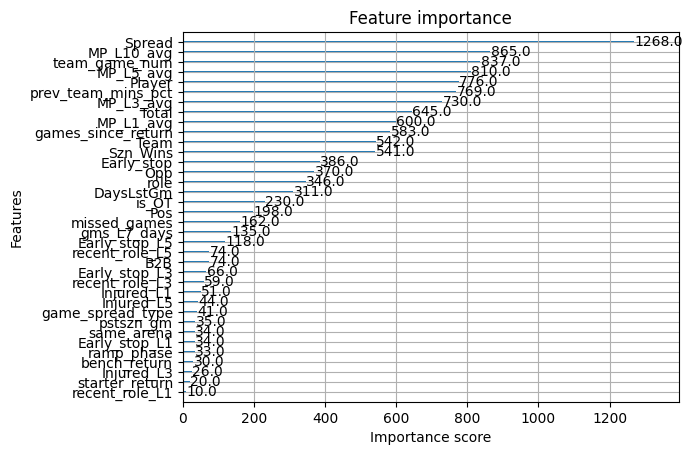

In [59]:
df_mins = df.copy()
df_mins = setup_df_mins(con, df_mins)
display(df_mins)

n = len(df_mins)
train_end = int(0.8 * n)
val_end   = int(0.9 * n)
mins_train_df = df_mins.iloc[:train_end]
mins_val_df   = df_mins.iloc[train_end:val_end]
mins_test_df  = df_mins.iloc[val_end:]
mins_DFS = (mins_train_df, mins_val_df, mins_test_df)

# mins_model = create_baseline_model(df_mins, "MP", mins_DFS)
mins_model, mins_preds, y_test_mins, analyze_df_mins = hyperparam_tuning(mins_DFS, "MP", n_iter=1)
feature_importance(mins_model, df_mins.columns.tolist())

# mins_model.save_model("../ML_models/mins_model.json")
# print('Saved minutes model!')

,Date,Team,Opp,Player,Pos,B2B,Spread,Total,team_game_num,Szn_Wins,pstszn_gm,is_OT,MP_L1_avg,MP_L3_avg,MP_L5_avg,MP_L10_avg,gms_L7_days,prev_team_mins_pct,role,recent_role_L1,recent_role_L3,recent_role_L5,missed_games,game_spread_type,games_since_return,ramp_phase,starter_return,bench_return,Early_stop,Early_stop_L1,Injured_L1,Early_stop_L3,Injured_L3,Early_stop_L5,Injured_L5,DaysLstGm,same_arena,MP,MP_preds,Diff,Diff2
5356,2025-11-20,PHI,MIL,VJ Edgecombe,SG,1,9.0,237.0,15,9,0,1,37.10,37.290000,35.640,36.125,3,0.154583,1,1,1,1,0,2,14,3,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,38.22,41.431129,-3.211129,3.211129
6753,2025-11-30,PHI,ATL,VJ Edgecombe,SG,0,-8.0,276.0,19,10,0,2,38.22,37.546667,36.948,35.974,0,0.159250,1,1,1,1,3,1,0,1,1,0,1,0.0,1.0,0.0,1.0,0.0,1.0,10,0,21.42,18.155130,3.264870,3.264870
7052,2025-12-02,PHI,WAS,VJ Edgecombe,SG,1,19.0,223.0,20,11,0,0,21.42,32.246667,34.302,34.831,1,0.089250,1,2,1,1,0,3,1,2,0,0,0,1.0,0.0,1.0,1.0,1.0,1.0,2,0,23.72,30.078598,-6.358598,6.358598
7330,2025-12-04,PHI,GSW,VJ Edgecombe,SG,0,1.0,197.0,21,12,0,0,23.72,27.786667,31.556,33.431,2,0.098833,1,2,2,1,0,1,2,2,0,0,0,0.0,0.0,1.0,1.0,1.0,1.0,2,0,23.85,32.966381,-9.116381,9.116381
7546,2025-12-05,PHI,MIL,VJ Edgecombe,SG,1,15.0,217.0,22,13,0,0,23.85,22.996667,28.862,32.094,3,0.099375,1,2,2,2,0,3,3,3,0,0,0,0.0,0.0,1.0,0.0,1.0,1.0,1,0,24.43,30.178154,-5.748154,5.748154
7840,2025-12-07,PHI,LAL,VJ Edgecombe,SG,0,-4.0,220.0,23,13,0,0,24.43,24.000000,26.328,30.984,4,0.101792,1,2,2,2,0,1,4,3,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,2,0,37.82,30.824223,6.995777,6.995777


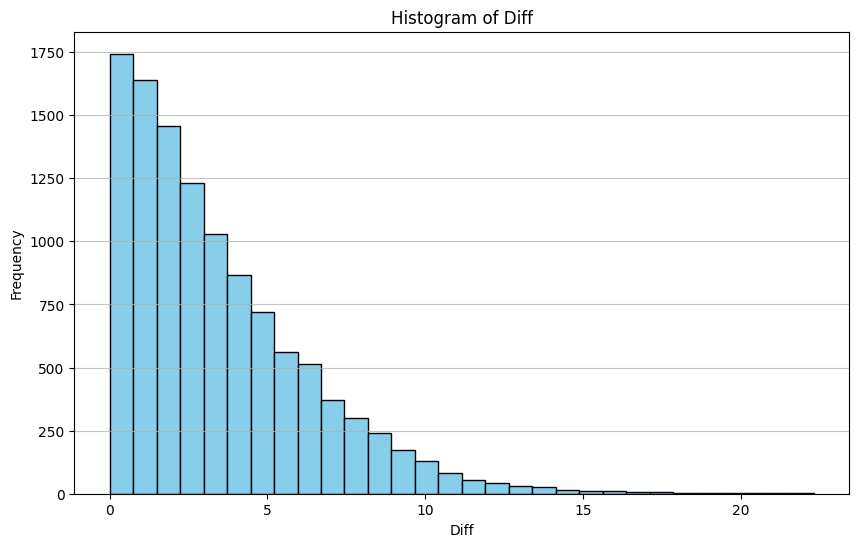

In [55]:
analyze_df_mins = mins_test_df.drop(['MP', 'MP_preds'], axis=1)\
                .merge(analyze_df_mins[['Date', 'Team', 'Player', 'MP', 'MP_preds']], on=['Date', 'Team', 'Player'])
analyze_df_mins['Diff'] = analyze_df_mins['MP'] - analyze_df_mins[f'MP_preds']
analyze_df_mins['Diff2'] = abs(analyze_df_mins['Diff'])
analyze_df_mins.sort_values('Diff2', ascending=False).drop('Diff2', axis=1).head(15)
display(analyze_df_mins[(analyze_df_mins.Date.isin(['2025-11-20', '2025-11-30', '2025-12-02', '2025-12-04', '2025-12-05', '2025-12-07'])) & (analyze_df_mins.Player == 'VJ Edgecombe')])
# display(analyze_df_mins[(analyze_df_mins.Diff < -15)])

plt.figure(figsize=(10,6))
plt.hist(analyze_df_mins['Diff2'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Diff')
plt.xlabel('Diff')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [13]:
rmse = np.sqrt(mean_squared_error(y_test_mins, mins_preds)) # splits[5] = y_test
mae = mean_absolute_error(y_test_mins, mins_preds)
print('RMSE:', rmse)

df_yesterday = pd.read_csv(f'../tables/2025/gmday_preds_{tgt_stat}.csv')
df_yesterday['Date'] = pd.to_datetime(df_yesterday.Date)
df_yesterday = df_yesterday[(df_yesterday.Date == (datetime.strptime(now, "%Y-%m-%d") - timedelta(days=1)).strftime("%Y-%m-%d"))]\
                .rename(columns={"MP": "MP_proj"})

df_gms = pd.read_csv(f"../tables/2025/season_gamelogs.csv")
df_gms['Date'] = pd.to_datetime(df_gms.Date)

df_yesterday = df_yesterday.merge(df_gms[['Date', 'Team', 'Player', 'MP']], on=['Date', 'Team', 'Player'])
df_yesterday = df_yesterday[['Date', 'Team', 'Player', 'Pos', 'Opp', 'MP_proj', 'MP', 'MP_last_5_avg']][df_yesterday.MP > 0]

df_yesterday['Diff'] = abs(df_yesterday['MP_proj'] - df_yesterday['MP'])
df_yesterday['InRMSE_Range'] = np.where(df_yesterday['Diff'] <= rmse, 1, 0)

print("\nYesterday's Results:")
print("Total Accuracy (InRMSE_Range):", ((df_yesterday.InRMSE_Range == 1).sum() / df_yesterday.shape[0]))
print((df_yesterday.InRMSE_Range == 1).sum(), '/', df_yesterday.shape[0])

df_yesterday = df_yesterday.drop(['Diff'], axis=1)

if df_yesterday.shape[0] >= 50:
    for tm in df_yesterday.Team.unique():
        display(df_yesterday[df_yesterday.Team == tm])
else:
    display(df_yesterday)

RMSE: 4.742634824064262

Yesterday's Results:
Total Accuracy (InRMSE_Range): 0.6
30 / 50


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
0,2026-01-04,MIL,Giannis Antetokounmpo,PF,SAC,28.716665,31.62,27.982349,1
9,2026-01-04,MIL,Bobby Portis,PF,SAC,24.161585,16.08,26.135959,0
22,2026-01-04,MIL,Kevin Porter Jr.,PG,SAC,36.594959,39.73,35.855889,1
25,2026-01-04,MIL,Myles Turner,C,SAC,27.546740,31.92,28.555355,1
31,2026-01-04,MIL,Kyle Kuzma,PF,SAC,31.004221,17.72,29.381235,0
47,2026-01-04,MIL,Ryan Rollins,PG,SAC,32.635799,33.87,29.896870,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
1,2026-01-04,LAL,Luka Doncic,PG,MEM,35.944408,38.88,32.557840,1
12,2026-01-04,LAL,LeBron James,SF,MEM,34.308392,37.28,31.004524,1
38,2026-01-04,LAL,Marcus Smart,SG,MEM,30.235998,31.15,26.220585,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
2,2026-01-04,MEM,Cedric Coward,SG,LAL,27.179178,12.55,27.088573,0
3,2026-01-04,MEM,Jaren Jackson Jr.,C,LAL,33.153820,33.68,31.794063,1
7,2026-01-04,MEM,Santi Aldama,PF,LAL,33.201035,30.73,32.327365,1
20,2026-01-04,MEM,Jaylen Wells,SG,LAL,30.869301,24.50,31.706475,0
30,2026-01-04,MEM,Kentavious Caldwell-Pope,SG,LAL,21.345865,24.77,21.460525,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
4,2026-01-04,PHO,Collin Gillespie,PG,OKC,31.103773,25.87,31.621266,0
17,2026-01-04,PHO,Royce O'Neale,SF,OKC,30.207739,31.52,28.232986,1
32,2026-01-04,PHO,Devin Booker,SG,OKC,31.891191,38.18,32.009168,0
40,2026-01-04,PHO,Dillon Brooks,SF,OKC,30.043388,33.55,29.833093,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
5,2026-01-04,SAC,Zach LaVine,SG,MIL,27.371515,35.53,29.441465,0
16,2026-01-04,SAC,Dennis Schroder,PG,MIL,26.097654,26.12,25.478792,1
19,2026-01-04,SAC,Russell Westbrook,PG,MIL,28.278721,37.90,29.423325,0
23,2026-01-04,SAC,DeMar DeRozan,PF,MIL,33.489761,28.72,30.823483,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
6,2026-01-04,WAS,Bilal Coulibaly,SG,MIN,28.338726,27.57,27.219705,1
26,2026-01-04,WAS,Tre Johnson,SG,MIN,24.548428,26.97,21.953369,1
39,2026-01-04,WAS,Khris Middleton,SF,MIN,22.494070,17.85,22.027139,1
42,2026-01-04,WAS,CJ McCollum,SG,MIN,32.581181,22.17,32.002085,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
8,2026-01-04,NOP,Derik Queen,C,MIA,24.408648,29.62,29.976113,0
11,2026-01-04,NOP,Jordan Poole,PG,MIA,27.864929,24.60,27.164409,1
15,2026-01-04,NOP,Zion Williamson,PF,MIA,30.086285,26.22,28.067300,1
37,2026-01-04,NOP,Jeremiah Fears,PG,MIA,28.162432,26.12,26.608550,1
48,2026-01-04,NOP,Trey Murphy III,SF,MIA,30.087290,38.20,34.530594,0
49,2026-01-04,NOP,Jose Alvarado,PG,MIA,21.066376,19.73,21.807204,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
10,2026-01-04,MIN,Rudy Gobert,C,WAS,31.442608,29.32,31.432102,1
13,2026-01-04,MIN,Jaden McDaniels,PF,WAS,30.742990,21.88,31.086528,0
14,2026-01-04,MIN,Donte DiVincenzo,SG,WAS,31.456375,22.58,31.345453,0
24,2026-01-04,MIN,Anthony Edwards,SG,WAS,35.922852,30.17,35.433493,0
33,2026-01-04,MIN,Naz Reid,C,WAS,27.781271,20.12,29.060118,0
45,2026-01-04,MIN,Julius Randle,PF,WAS,34.668571,25.30,33.092903,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
18,2026-01-04,OKC,Shai Gilgeous-Alexander,PG,PHO,34.434029,35.65,30.886402,1
21,2026-01-04,OKC,Jalen Williams,SG,PHO,29.167980,34.48,28.404469,0
28,2026-01-04,OKC,Chet Holmgren,PF,PHO,30.221292,32.60,27.207377,1
35,2026-01-04,OKC,Cason Wallace,SG,PHO,26.474220,17.85,25.594665,0
36,2026-01-04,OKC,Ajay Mitchell,SG,PHO,26.505939,27.20,24.326729,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,MP_last_5_avg,InRMSE_Range
27,2026-01-04,MIA,Andrew Wiggins,SF,NOP,30.933498,28.35,30.093023,1
29,2026-01-04,MIA,Pelle Larsson,SG,NOP,18.700235,25.58,20.495099,0
34,2026-01-04,MIA,Nikola Jovic,PF,NOP,23.624006,25.78,16.423217,1
41,2026-01-04,MIA,Bam Adebayo,C,NOP,32.556572,28.78,30.505844,1
43,2026-01-04,MIA,Norman Powell,SG,NOP,32.496151,28.78,30.978225,1
44,2026-01-04,MIA,Davion Mitchell,PG,NOP,31.807127,29.32,27.771830,1
46,2026-01-04,MIA,Kel'el Ware,C,NOP,28.307058,24.63,26.672721,1


# Main Model

In [19]:
def setup_df_main(df):
    
    # Stat dependent features 
    if tgt_stat == 'PTS':
        tgt_stat_cols = ['TPM', 'FG', 'FT']
        df = df[['Season', 'Date', 'Team', 'Opp', 'Player', 'Pos', 'MP', 
         'PTS', 'TPM', 'FG', 'FGA', 'TPA', 'FT', 'FTA', 
         f'Off_{tgt_stat}', f'Off_L3_{tgt_stat}', f'Off_L5_{tgt_stat}', f'Off_L10_{tgt_stat}', f'Off_{tgt_stat}_Rk',
         f'Def_{tgt_stat}', f'Def_L3_{tgt_stat}', f'Def_L5_{tgt_stat}', f'Def_L10_{tgt_stat}', f'Def_{tgt_stat}_Rk',
         'Spread', 'Total', 'is_OT']]
        
        # Efficiency metrics
        df['three_rate_raw'] =  np.where(df.FGA > 0, df['TPA'] / df['FGA'], 0)
        df['ft_rate_raw']    =  np.where(df.FGA > 0, df['FTA'] / df['FGA'], 0)
        df['eFG_raw'] = (df['FG'] + 0.5 * df['TPM']) / df['FGA']
        df['TS_raw'] = df['PTS'] / (2 * (df['FGA'] + 0.44 * df['FTA']))    
        df['usage_proxy_raw'] =  np.where(df.MP > 0, (df['FGA'] + 0.44 * df['FTA']) / df['MP'], 0)
        
        for w in [3, 5, 10]:
            for metric in ['three_rate', 'ft_rate', 'eFG', 'TS', 'usage_proxy']:
                col = f"{metric}_L{w}"
                df[col] = (
                    df.groupby(['Player','Season'])[f'{metric}_raw']
                      .rolling(w, min_periods=1)
                      .mean()
                      .shift(1)
                      .reset_index(level=[0,1], drop=True)
                )
        for metric in ['three_rate', 'ft_rate', 'eFG', 'TS', 'usage_proxy']:
            col = f'{metric}_weighted'
            df[col] = (
                0.6 * df[f'{metric}_L3'] +
                0.3 * df[f'{metric}_L5'] +
                0.1 * df[f'{metric}_L10']
            )
            df = df.drop(f'{metric}_raw', axis=1)
        
    elif tgt_stat == 'PRA':
        tgt_stat_cols = ['PTS', 'REB', 'AST', 'TOV', 'TPM', 'FG', 'FT']
        df = df[['Season', 'Date', 'Team', 'Opp', 'Player', 'Pos', 'MP', 
         'PTS', 'AST', 'REB', 'PR', 'PA', 'RA', 'PRA', 'TPM', 'STL', 'BLK', 'STL_BLK', 'TOV',
         'FG', 'FGA', 'TPA', 'FT', 'FTA', 
         f'Off_{tgt_stat}', f'Off_L3_{tgt_stat}', f'Off_L5_{tgt_stat}', f'Off_L10_{tgt_stat}', f'Off_{tgt_stat}_Rk',
         f'Def_{tgt_stat}', f'Def_L3_{tgt_stat}', f'Def_L5_{tgt_stat}', f'Def_L10_{tgt_stat}', f'Def_{tgt_stat}_Rk',
         'Spread', 'Total', 'is_OT']]
        
        df['usage_proxy_raw'] =  np.where(df.MP > 0, (df['FGA'] + 0.44 * df['FTA']) / df['MP'], 0)
        for w in [3, 5, 10]:
            df[f"usage_proxy_L{w}"] = (
                df.groupby(['Player','Season'])[f'usage_proxy_raw']
                  .rolling(w, min_periods=1)
                  .mean()
                  .shift(1)
                  .reset_index(level=[0,1], drop=True)
            )
        df['usage_proxy_weighted'] = (
            0.6 * df[f'usage_proxy_L3'] +
            0.3 * df[f'usage_proxy_L5'] +
            0.1 * df[f'usage_proxy_L10']
        )
        df = df.drop('usage_proxy_raw', axis=1)
        
        
    else:
        tgt_stat_cols = []
        df = df[['Season', 'Date', 'Team', 'Opp', 'Player', 'Pos', 'MP', 
         'PTS', 'AST', 'REB', 'PR', 'PA', 'RA', 'PRA', 'TPM', 'STL', 'BLK', 'STL_BLK',
         'FG', 'FGA', 'TPA', 'FT', 'FTA', 
          f'Off_{tgt_stat}', f'Off_L3_{tgt_stat}', f'Off_L5_{tgt_stat}', f'Off_L10_{tgt_stat}', f'Off_{tgt_stat}_Rk',
          f'Def_{tgt_stat}', f'Def_L3_{tgt_stat}', f'Def_L5_{tgt_stat}', f'Def_L10_{tgt_stat}', f'Def_{tgt_stat}_Rk',
         'Spread', 'Total', 'is_OT']]

    
    # Create rolling + lag features    
    for col in ['MP', 'FGA', 'TPA', 'FTA'] + tgt_stat_cols:
        df[f'{col}_lst_gm'] = (
            df
            .groupby(['Player', 'Season'])[col]
            .shift(1)
        )
        for N in [3, 5, 10]:
            df[f'{col}_last_{N}_avg'] = (
                df.groupby(['Player', 'Season'])[col]
                  .rolling(window=N, min_periods=1)
                  .mean()
                  .shift(1)
                  .reset_index(level=[0, 1], drop=True)
            )
            df[f"{col}_last_{N}_std"] = (
                df.groupby(['Player', 'Season'])[col]
                  .shift(1)
                  .rolling(window=N, min_periods=1)
                  .std()
            )

    # Role identifiers features
    df['reserve_td'] = (df.MP < 8).astype(int)
    df['bench_td']   = ((df.MP >= 8) & (df.MP <= 25)).astype(int)
    df['starter_td'] = (df.MP > 25).astype(int)
    role_counts = df.groupby(['Season', 'Player'])[['reserve_td', 'bench_td', 'starter_td']].sum()
    role_counts['most_common_role'] = role_counts[['reserve_td', 'bench_td', 'starter_td']].idxmax(axis=1)
    role_counts['reserve'] = (role_counts['most_common_role'] == 'reserve_td').astype(int)
    role_counts['bench']   = (role_counts['most_common_role'] == 'bench_td').astype(int)
    role_counts['starter'] = (role_counts['most_common_role'] == 'starter_td').astype(int)
    df = df.merge(role_counts[['reserve', 'bench', 'starter']], on=['Season', 'Player'], how='left')
    df['role'] = 0
    df['role'] = np.where(df.starter == 1, 1, df.role)
    df['role'] = np.where(df.bench == 1, 2, df.role)
    df['role'] = np.where(df.reserve == 1, 3, df.role)
    
    # Other features
    df["DaysLstGm"] = (df.groupby("Player")["Date"].diff().dt.days).fillna(0).astype(int)
    
    for col in categories + ['Season', 'FG', 'FGA', 'FT', 'FTA', 'TPM', 'TPA', 
                             'reserve_td', 'reserve', 'bench_td', 'bench', 'starter_td', 'starter'] + tgt_stat_cols:
        if col == tgt_stat:
            continue
        if col in df.columns:
            df = df.drop(col, axis=1)
        
    return df

In [42]:
df_main = df[df.Season >= 2022].copy()
df_main = setup_df_main(df_main)
display(df_main)

n = len(df_main)
train_end = int(0.65 * n)
val_end   = int(0.85 * n)
main_train_df = df_main.iloc[:train_end]
main_val_df   = df_main.iloc[train_end:val_end]
main_test_df  = df_main.iloc[val_end:]
main_DFS = (main_train_df, main_val_df, main_test_df)

# stat_model = create_baseline_model(df_main, tgt_stat, main_DFS)
stat_model, stat_preds, y_test_stat, analyze_df_stat = hyperparam_tuning(main_DFS, tgt_stat, n_iter=1)
# feature_importance(stat_model, df_main.columns.tolist())

# stat_model.save_model(f"../ML_models/{tgt_stat}_model.json")
# print(f'Saved {tgt_stat} model!')

,Date,Team,Opp,Player,Pos,MP,PTS,Off_PTS,Off_L3_PTS,Off_L5_PTS,Off_L10_PTS,Off_PTS_Rk,Def_PTS,Def_L3_PTS,Def_L5_PTS,Def_L10_PTS,Def_PTS_Rk,Spread,Total,is_OT,three_rate_L3,ft_rate_L3,eFG_L3,TS_L3,usage_proxy_L3,three_rate_L5,ft_rate_L5,eFG_L5,TS_L5,usage_proxy_L5,three_rate_L10,ft_rate_L10,eFG_L10,TS_L10,usage_proxy_L10,three_rate_weighted,ft_rate_weighted,eFG_weighted,TS_weighted,usage_proxy_weighted,MP_lst_gm,MP_last_3_avg,MP_last_3_std,MP_last_5_avg,MP_last_5_std,MP_last_10_avg,MP_last_10_std,FGA_lst_gm,FGA_last_3_avg,FGA_last_3_std,FGA_last_5_avg,FGA_last_5_std,FGA_last_10_avg,FGA_last_10_std,TPA_lst_gm,TPA_last_3_avg,TPA_last_3_std,TPA_last_5_avg,TPA_last_5_std,TPA_last_10_avg,TPA_last_10_std,FTA_lst_gm,FTA_last_3_avg,FTA_last_3_std,FTA_last_5_avg,FTA_last_5_std,FTA_last_10_avg,FTA_last_10_std,TPM_lst_gm,TPM_last_3_avg,TPM_last_3_std,TPM_last_5_avg,TPM_last_5_std,TPM_last_10_avg,TPM_last_10_std,FG_lst_gm,FG_last_3_avg,FG_last_3_std,FG_last_5_avg,FG_last_5_std,FG_last_10_avg,FG_last_10_std,FT_lst_gm,FT_last_3_avg,FT_last_3_std,FT_last_5_avg,FT_last_5_std,FT_last_10_avg,FT_last_10_std,role,DaysLstGm
0,2022-10-18,1,22,19,0,23.10,6.0,6.000000,6.000000,6.0,6.0,5.0,8.000000,8.0,8.0,8.0,2.0,9.0,243.0,0,0.242063,0.814815,0.803571,0.840041,0.333084,0.309127,0.633333,0.690476,0.738062,0.381789,0.282640,0.518718,0.635430,0.692661,0.413879,0.266240,0.730761,0.752829,0.794709,0.355775,NaN,25.150000,NaN,23.776,NaN,23.561,NaN,NaN,6.666667,NaN,7.4,NaN,8.4,NaN,NaN,1.666667,NaN,2.4,NaN,2.3,NaN,NaN,4.000000,NaN,3.6,NaN,3.1,NaN,NaN,1.000000,NaN,1.0,NaN,0.9,NaN,NaN,4.333333,NaN,4.2,NaN,4.5,NaN,NaN,4.000000,NaN,3.4,NaN,2.9,NaN,1,0
1,2022-10-18,1,22,71,0,8.28,1.0,1.000000,1.000000,1.0,1.0,7.0,8.000000,8.0,8.0,8.0,2.0,9.0,243.0,0,0.000000,0.000000,0.666667,0.666667,0.302402,0.000000,0.000000,0.666667,0.642045,0.286831,0.000000,0.000000,0.600000,0.594697,0.167386,0.000000,0.000000,0.660000,0.652083,0.284229,NaN,5.410000,NaN,3.964,NaN,6.374,NaN,NaN,1.333333,NaN,0.8,NaN,0.6,NaN,NaN,0.000000,NaN,0.0,NaN,0.0,NaN,NaN,0.000000,NaN,0.4,NaN,0.2,NaN,NaN,0.000000,NaN,0.0,NaN,0.0,NaN,NaN,1.000000,NaN,0.6,NaN,0.4,NaN,NaN,0.000000,NaN,0.2,NaN,0.1,NaN,2,0
2,2022-10-18,1,22,231,4,24.03,2.0,2.000000,2.000000,2.0,2.0,6.0,2.000000,2.0,2.0,2.0,1.0,9.0,243.0,0,0.083333,0.000000,0.550000,0.550000,0.321647,0.140476,0.100000,0.572857,0.582147,0.371026,0.220238,0.111111,0.543373,0.559687,0.392727,0.114167,0.041111,0.556194,0.560613,0.343569,NaN,11.733333,NaN,13.474,NaN,12.434,NaN,NaN,3.666667,NaN,4.8,NaN,4.7,NaN,NaN,0.333333,NaN,0.8,NaN,1.1,NaN,NaN,0.000000,NaN,0.6,NaN,0.6,NaN,NaN,0.000000,NaN,0.4,NaN,0.5,NaN,NaN,2.000000,NaN,2.6,NaN,2.4,NaN,NaN,0.000000,NaN,0.4,NaN,0.5,NaN,1,0
3,2022-10-18,1,22,317,1,23.95,15.0,15.000000,15.000000,15.0,15.0,2.0,15.000000,15.0,15.0,15.0,3.0,9.0,243.0,0,0.657143,0.419048,0.404762,0.457749,0.394162,0.527619,0.284762,0.409524,0.452289,0.359923,0.574365,0.228492,0.395317,0.440909,0.378902,0.610008,0.359706,0.405246,0.454427,0.382364,NaN,14.130000,NaN,15.152,NaN,15.162,NaN,NaN,4.666667,NaN,4.8,NaN,5.2,NaN,NaN,2.666667,NaN,2.2,NaN,2.8,NaN,NaN,2.666667,NaN,1.8,NaN,1.3,NaN,NaN,1.000000,NaN,0.6,NaN,0.8,NaN,NaN,2.000000,NaN,2.0,NaN,1.9,NaN,NaN,2.333333,NaN,1.6,NaN,1.1,NaN,1,0
4,2022-10-18,1,22,431,3,38.57,35.0,35.000000,35.000000,35.0,35.0,1.0,70.000000,70.0,70.0,70.0,3.0,9.0,243.0,0,0.166667,0.166667,0.916667,0.899709,0.322357,0.166667,0.166667,0.916667,0.899709,0.322357,0.166667,0.166667,0.916667,0.899709,0.322357,0.166667,0.166667,0.916667,0.899709,0.322357,NaN,15.055000,NaN,15.055,NaN,15.055,NaN,NaN,3.500000,NaN,3.5,NaN,3.5,NaN,NaN,1.000000,NaN,1.0,NaN,1.0,NaN,NaN,1.000000,NaN,1.0,NaN,1.0,NaN,NaN,1.000000,NaN,1.0,NaN,1.0,NaN,NaN,2.500000,NaN,2.5,NaN,2.5,NaN,NaN,0.500000,NaN,0.5,NaN,0.5,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.


Trial 1/1: {'n_estimators': 331, 'learning_rate': np.float64(0.027780795420054218), 'max_depth': 5, 'min_child_weight': 1, 'subsample': np.float64(0.8034569262759739), 'colsample_bytree': np.float64(0.7330896951286463), 'gamma': np.float64(1.4184417082461682), 'reg_lambda': np.float64(3.1614678613744314), 'reg_alpha': np.float64(1.2502628072797146)}
Validation MAE: 2.0897

Best validation MAE: 2.089677284311482
Best parameters: {'learning_rate': np.float64(0.027780795420054218), 'max_depth': 5, 'min_child_weight': 1, 'subsample': np.float64(0.8034569262759739), 'colsample_bytree': np.float64(0.7330896951286463), 'gamma': np.float64(1.4184417082461682), 'reg_lambda': np.float64(3.1614678613744314), 'reg_alpha': np.float64(1.2502628072797146), 'objective': 'reg:squarederror', 'tree_method': 'hist', 'device': 'cuda', 'seed': 42}

Test Metrics:
RMSE: 2.9192331872224626
MAE: 2.13079993439592
R²: 0.8966665053525446


In [43]:
# analyze_df_stat = main_test_df.drop([tgt_stat, f'{tgt_stat}_preds'], axis=1)\
#                 .merge(analyze_df_stat[['Date', 'Team', 'Player', tgt_stat, f'{tgt_stat}_preds']], on=['Date', 'Team', 'Player'])
# analyze_df_stat['Diff'] = analyze_df_stat[tgt_stat] - analyze_df_stat[f'{tgt_stat}_preds']
# analyze_df_stat['Diff2'] = abs(analyze_df_stat['Diff'])
# analyze_df_stat.sort_values('Diff2', ascending=False).drop('Diff2', axis=1).head(15)
# display(analyze_df_stat[(analyze_df_stat.Date == '2026-01-04') & (analyze_df_stat.Team == 'LAL')])

In [48]:
rmse = np.sqrt(mean_squared_error(y_test_stat, stat_preds)) # splits[5] = y_test
mae = mean_absolute_error(y_test_stat, stat_preds)
print('RMSE:', rmse)

df_yesterday = pd.read_csv(f'../tables/2025/gmday_preds_{tgt_stat}.csv')
df_yesterday['Date'] = pd.to_datetime(df_yesterday.Date)
df_yesterday = df_yesterday[(df_yesterday.Date == (datetime.strptime(now, "%Y-%m-%d") - timedelta(days=1)).strftime("%Y-%m-%d"))]\
                .rename(columns={"MP": "MP_proj"})

df_gms = pd.read_csv(f"../tables/2025/season_gamelogs.csv")
df_gms['Date'] = pd.to_datetime(df_gms.Date)
df_gms = df_gms.rename(columns={"TRB": "REB", "3PM": "TPM", "3PA": "TPA"})
df_gms['STL_BLK'] = df_gms.STL + df_gms.BLK
df_gms['PR'] = df_gms.PTS + df_gms.REB 
df_gms['PA'] = df_gms.PTS + df_gms.AST
df_gms['RA'] = df_gms.REB + df_gms.AST
df_gms['PRA'] = df_gms.PTS + df_gms.REB + df_gms.AST

df_yesterday = df_yesterday.merge(df_gms[['Date', 'Team', 'Player', tgt_stat, 'MP']], on=['Date', 'Team', 'Player'])
df_yesterday = df_yesterday[['Date', 'Team', 'Player', 'Pos', 'Opp', 'MP_proj', 'MP', f'{tgt_stat}_line', f'{tgt_stat}_proj', tgt_stat]][df_yesterday.MP > 0]

df_yesterday['Diff'] = df_yesterday[f'{tgt_stat}_proj'] - df_yesterday[f'{tgt_stat}_line']
df_yesterday['Diff2'] = abs(df_yesterday[f'{tgt_stat}_proj'] - df_yesterday[tgt_stat])
df_yesterday['Act_Res'] = np.where(df_yesterday[tgt_stat] > df_yesterday[f'{tgt_stat}_line'], 'O', 'U')
df_yesterday['Pred_Res'] = np.where(df_yesterday[f'{tgt_stat}_proj'] > df_yesterday[f'{tgt_stat}_line'], 'O', 'U')
df_yesterday['ParlayHit'] = np.where(df_yesterday['Act_Res'] == df_yesterday['Pred_Res'], 1, 0)
df_yesterday['InRMSE_Range'] = np.where(df_yesterday['Diff2'] <= rmse, 1, 0)
# df_yesterday = df_yesterday[(abs(df_yesterday.Diff) > rmse)]
# df_yesterday = df_yesterday[df_yesterday.InRMSE_Range == 0]

print("Total Accuracy (ParlayHit):", ((df_yesterday.ParlayHit == 1).sum() / df_yesterday.shape[0]))
print((df_yesterday.ParlayHit == 1).sum(), "/", df_yesterday.shape[0])

print("\nTotal Accuracy (InRMSE_Range):", ((df_yesterday.InRMSE_Range == 1).sum() / df_yesterday.shape[0]))
print((df_yesterday.InRMSE_Range == 1).sum(), "/", df_yesterday.shape[0])

df_yesterday = df_yesterday.drop(['Diff', 'Diff2', 'Act_Res', 'Pred_Res'], axis=1).sort_values(f'{tgt_stat}_line', ascending=False)

if df_yesterday.shape[0] >= 50:
    for tm in df_yesterday.Team.unique():
        display(df_yesterday[(df_yesterday.Team == tm)]) #  & (df_yesterday.ParlayHit == 1)
else:
    display(df_yesterday)

RMSE: 2.9192331872224626
Total Accuracy (ParlayHit): 0.4175824175824176
38 / 91

Total Accuracy (InRMSE_Range): 0.3516483516483517
32 / 91


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
6,2026-01-04,LAL,Luka Doncic,PG,MEM,35.530140,38.88,35.5,29.425018,36,0,0
34,2026-01-04,LAL,LeBron James,SF,MEM,33.629990,37.28,23.5,20.777567,26,0,0
77,2026-01-04,LAL,Jake LaRavia,PF,MEM,30.311096,34.50,12.5,11.892099,26,0,0
38,2026-01-04,LAL,Deandre Ayton,C,MEM,28.420122,33.57,12.5,9.941256,15,0,0
62,2026-01-04,LAL,Marcus Smart,SG,MEM,29.761141,31.15,10.5,11.740422,6,0,0
67,2026-01-04,LAL,Jaxson Hayes,C,MEM,18.542831,14.43,6.5,7.534648,1,0,0
64,2026-01-04,LAL,Jarred Vanderbilt,PF,MEM,20.961756,21.95,5.5,6.630007,7,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
42,2026-01-04,OKC,Shai Gilgeous-Alexander,PG,PHO,33.915668,35.65,31.5,29.364738,25,1,0
22,2026-01-04,OKC,Jalen Williams,SG,PHO,28.511902,34.48,17.5,14.320476,23,0,0
23,2026-01-04,OKC,Chet Holmgren,PF,PHO,29.873045,32.60,16.5,19.569561,18,1,1
56,2026-01-04,OKC,Ajay Mitchell,SG,PHO,26.103598,27.20,12.5,13.827897,13,1,1
89,2026-01-04,OKC,Aaron Wiggins,SG,PHO,21.226280,19.28,9.5,9.222972,5,1,0
48,2026-01-04,OKC,Cason Wallace,SG,PHO,26.628942,17.85,7.5,9.163237,3,0,0
84,2026-01-04,OKC,Luguentz Dort,SF,PHO,27.252378,26.52,6.5,6.818851,13,1,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
24,2026-01-04,MIN,Anthony Edwards,SG,WAS,35.905300,30.17,30.5,27.475674,35,0,0
60,2026-01-04,MIN,Julius Randle,PF,WAS,34.265678,25.30,21.5,22.794731,22,1,1
5,2026-01-04,MIN,Naz Reid,C,WAS,27.860161,20.12,14.5,20.678717,9,0,0
35,2026-01-04,MIN,Jaden McDaniels,PF,WAS,30.098097,21.88,13.5,10.793336,12,1,1
32,2026-01-04,MIN,Donte DiVincenzo,SG,WAS,30.702559,22.58,12.5,9.702487,5,1,0
50,2026-01-04,MIN,Rudy Gobert,C,WAS,31.641565,29.32,11.5,9.926951,18,0,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
1,2026-01-04,MIL,Giannis Antetokounmpo,PF,SAC,28.480701,31.62,29.5,19.889799,37,0,0
26,2026-01-04,MIL,Kevin Porter Jr.,PG,SAC,36.455505,39.73,17.5,14.562097,25,0,0
61,2026-01-04,MIL,Ryan Rollins,PG,SAC,31.941858,33.87,15.5,16.771965,12,0,0
70,2026-01-04,MIL,Bobby Portis,PF,SAC,23.641373,16.08,12.5,13.472248,9,0,0
86,2026-01-04,MIL,Kyle Kuzma,PF,SAC,29.801361,17.72,11.5,11.791162,3,0,0
4,2026-01-04,MIL,Myles Turner,C,SAC,27.853252,31.92,10.5,16.727028,15,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
51,2026-01-04,CLE,Donovan Mitchell,SG,DET,34.247589,33.08,28.5,26.935966,30,0,0
79,2026-01-04,CLE,Darius Garland,PG,DET,32.487499,32.13,17.5,17.983263,16,0,1
13,2026-01-04,CLE,Evan Mobley,PF,DET,31.198790,32.75,16.5,12.340613,15,1,1
40,2026-01-04,CLE,De'Andre Hunter,SF,DET,26.888300,24.10,13.5,11.228312,14,0,1
45,2026-01-04,CLE,Jaylon Tyson,SG,DET,27.216845,25.27,12.5,14.310860,6,0,0
0,2026-01-04,CLE,Sam Merrill,SG,DET,23.550919,27.25,9.5,19.787407,15,1,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
74,2026-01-04,BRK,Michael Porter Jr.,SF,DEN,31.644651,32.07,27.5,28.281786,27,0,1
8,2026-01-04,BRK,Day'Ron Sharpe,C,DEN,19.745663,32.10,12.5,7.480959,17,0,0
33,2026-01-04,BRK,Noah Clowney,PF,DEN,29.960150,29.12,11.5,8.722165,22,0,0
72,2026-01-04,BRK,Terance Mann,SG,DEN,26.127554,26.03,6.5,5.605024,6,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
59,2026-01-04,DET,Cade Cunningham,PG,CLE,35.431683,37.03,27.5,26.194145,27,1,1
21,2026-01-04,DET,Isaiah Stewart,C,CLE,24.026945,31.47,12.5,9.241933,8,1,1
30,2026-01-04,DET,Ausar Thompson,SF,CLE,27.259537,21.72,12.5,9.685979,8,1,1
18,2026-01-04,DET,Marcus Sasser,PG,CLE,12.129115,3.00,11.5,8.022791,0,1,0
15,2026-01-04,DET,Duncan Robinson,SF,CLE,26.208231,29.52,11.5,7.552246,12,0,0
29,2026-01-04,DET,Jaden Ivey,SG,CLE,19.048105,19.23,10.5,7.656539,7,1,1
58,2026-01-04,DET,Javonte Green,SG,CLE,21.515100,24.02,9.5,8.178356,11,0,1
12,2026-01-04,DET,Paul Reed,C,CLE,7.860435,30.13,7.5,3.236338,8,0,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
10,2026-01-04,ORL,Paolo Banchero,PF,IND,36.149956,36.15,25.5,20.933544,28,0,0
20,2026-01-04,ORL,Desmond Bane,SG,IND,34.898941,36.55,21.5,18.231533,31,0,0
7,2026-01-04,ORL,Anthony Black,PG,IND,34.568218,35.55,19.5,24.523800,27,1,1
75,2026-01-04,ORL,Wendell Carter Jr.,C,IND,31.493427,31.52,12.5,11.791741,18,0,0
82,2026-01-04,ORL,Goga Bitadze,C,IND,16.001284,16.48,6.5,6.935958,2,0,0
90,2026-01-04,ORL,Tyus Jones,PG,IND,20.738050,13.92,6.5,6.234659,3,1,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
63,2026-01-04,DEN,Jamal Murray,PG,BRK,36.312431,39.73,25.5,24.317053,27,0,1
68,2026-01-04,DEN,Peyton Watson,SF,BRK,32.882156,28.62,14.5,13.504377,23,0,0
43,2026-01-04,DEN,Aaron Gordon,PF,BRK,23.628725,21.23,12.5,10.482591,20,0,0
2,2026-01-04,DEN,Christian Braun,SG,BRK,27.538017,24.20,11.5,3.507168,3,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
81,2026-01-04,IND,Pascal Siakam,PF,ORL,33.805614,36.45,24.5,24.953512,34,1,0
36,2026-01-04,IND,Andrew Nembhard,PG,ORL,33.359459,35.48,18.5,15.796778,20,0,0
39,2026-01-04,IND,Aaron Nesmith,SF,ORL,29.206600,34.13,13.5,10.986235,25,0,0
88,2026-01-04,IND,T.J. McConnell,PG,ORL,17.348101,20.80,9.5,9.783926,10,1,1
85,2026-01-04,IND,Jay Huff,C,ORL,18.345234,17.23,7.5,7.204438,11,0,0
49,2026-01-04,IND,Ben Sheppard,SG,ORL,20.102419,24.35,6.5,8.107225,8,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
19,2026-01-04,NOP,Zion Williamson,PF,MIA,30.150599,26.22,24.5,27.965334,12,0,0
53,2026-01-04,NOP,Trey Murphy III,SF,MIA,29.734610,38.20,20.5,19.046286,27,0,0
17,2026-01-04,NOP,Jordan Poole,PG,MIA,27.910013,24.60,16.5,20.284595,8,0,0
46,2026-01-04,NOP,Jeremiah Fears,PG,MIA,27.707008,26.12,12.5,10.783546,21,0,0
47,2026-01-04,NOP,Derik Queen,C,MIA,24.684788,29.62,12.5,14.184892,13,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
78,2026-01-04,MIA,Norman Powell,SG,NOP,32.088047,28.78,24.5,25.039686,34,1,0
52,2026-01-04,MIA,Andrew Wiggins,SF,NOP,32.401409,28.35,17.5,15.987735,10,1,0
14,2026-01-04,MIA,Bam Adebayo,C,NOP,32.584702,28.78,17.5,13.382139,12,1,1
31,2026-01-04,MIA,Kel'el Ware,C,NOP,28.454071,24.63,13.5,16.310551,16,1,1
71,2026-01-04,MIA,Davion Mitchell,PG,NOP,31.737719,29.32,9.5,8.574310,9,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
27,2026-01-04,PHO,Devin Booker,SG,OKC,31.549294,38.18,23.5,26.403870,24,1,1
91,2026-01-04,PHO,Dillon Brooks,SF,OKC,30.011669,33.55,18.5,18.548943,22,1,0
16,2026-01-04,PHO,Collin Gillespie,PG,OKC,30.880175,25.87,13.5,17.313433,8,0,0
44,2026-01-04,PHO,Mark Williams,C,OKC,22.033995,21.28,10.5,12.469675,8,0,0
66,2026-01-04,PHO,Royce O'Neale,SF,OKC,29.493750,31.52,8.5,9.541388,3,0,0
65,2026-01-04,PHO,Oso Ighodaro,PF,OKC,22.144987,23.63,5.5,6.582074,5,0,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
9,2026-01-04,MEM,Jaren Jackson Jr.,C,LAL,33.197258,33.68,20.5,25.275604,14,0,0
25,2026-01-04,MEM,Santi Aldama,PF,LAL,33.054234,30.73,14.5,17.464043,12,0,0
11,2026-01-04,MEM,Cedric Coward,SG,LAL,27.743280,12.55,14.5,18.929033,16,1,0
37,2026-01-04,MEM,Jaylen Wells,SG,LAL,30.453861,24.50,13.5,10.864161,23,0,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
83,2026-01-04,SAC,DeMar DeRozan,PF,MIL,34.672501,28.72,19.5,19.174313,11,1,0
3,2026-01-04,SAC,Zach LaVine,SG,MIL,28.486666,35.53,16.5,23.567083,20,1,0
54,2026-01-04,SAC,Keegan Murray,PF,MIL,34.168648,26.72,15.5,14.087653,12,1,1
69,2026-01-04,SAC,Russell Westbrook,PG,MIL,28.383686,37.90,14.5,13.521154,21,0,0
87,2026-01-04,SAC,Maxime Raynaud,C,MIL,28.879982,24.13,12.5,12.215854,6,1,0
92,2026-01-04,SAC,Dennis Schroder,PG,MIL,26.608156,26.12,11.5,11.510719,13,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
76,2026-01-04,WAS,CJ McCollum,SG,MIN,31.834545,22.17,18.5,17.792765,20,0,1
55,2026-01-04,WAS,Tre Johnson,SG,MIN,24.575035,26.97,14.5,15.864750,13,0,1
41,2026-01-04,WAS,Bilal Coulibaly,SG,MIN,28.367390,27.57,10.5,12.715169,6,0,0
80,2026-01-04,WAS,Khris Middleton,SF,MIN,22.410961,17.85,9.5,9.033706,10,0,1
57,2026-01-04,WAS,Justin Champagnie,SF,MIN,24.012918,18.15,9.5,10.825013,6,0,0


### Today's predictions

In [269]:
df_lines = pd.read_csv(f"../tables/2025/parlay_lines.csv")
df_lines['Date'] = pd.to_datetime(df_lines.Date)
df_lines = df_lines[~(df_lines.Team.isnull())]

# Predict Mins
df_lines["Team"] = team_encoder.transform(df_lines["Team"])
df_pred = df_pred.merge(df_lines[['Date', 'Team', 'Spread', 'Total']], on=['Date', 'Team'], how='left')
df_pred = df_pred[~df_pred[['Date', 'Team', 'Player']].duplicated(keep='last')]
df_pred['Spread_x'] = np.where(df_pred.Spread_x.isnull(), df_pred.Spread_y, df_pred.Spread_x)
df_pred['Total_x'] = np.where(df_pred.Total_x.isnull(), df_pred.Total_y, df_pred.Total_x)
df_pred = df_pred.rename(columns={"Spread_x": "Spread", "Total_x": "Total"}).drop(['Spread_y', 'Total_y'], axis=1)
df_pred_mins = setup_df_mins(con, df_pred)
df_pred_mins = df_pred_mins.drop(['Date', 'MP'], axis=1)
DM_mins = xgb.DMatrix(df_pred_mins)
df_pred['MP'] = mins_model.predict(DM_mins)

# Predict Stat
df_pred = setup_df_main(df_pred)
feature_cols = [col for col in df_pred.columns if col not in ['Date', tgt_stat]]
df_pred = df_pred[df_pred.Date == now][feature_cols]
DM_stats = xgb.DMatrix(df_pred)
df_pred[f"{tgt_stat}_proj"] = stat_model.predict(DM_stats)

df_pred['Team'] = team_encoder.inverse_transform(df_pred["Team"])
df_lines['Team'] = team_encoder.inverse_transform(df_lines["Team"])
df_pred['Opp'] = team_encoder.inverse_transform(df_pred["Opp"])
df_pred['Player'] = player_encoder.inverse_transform(df_pred["Player"])
df_pred['Pos'] = position_encoder.inverse_transform(df_pred["Pos"])

df_lines = df_lines[df_lines.Date == now][['Team', 'Player', f'{tgt_stat}_line']]
df_pred = df_pred.merge(df_lines, on=['Team', 'Player'])

tds_picks = df_pred[~(df_pred[f'{tgt_stat}_line'].isnull())]\
            [['Team', 'Player', 'Pos', 'Opp', 'MP', 'MP_last_5_avg', f'{tgt_stat}_line', f'{tgt_stat}_proj']]
tds_picks['Diff'] = abs((df_pred[f'{tgt_stat}_line'] - df_pred[f'{tgt_stat}_proj']))
tds_picks['Diff2'] = abs((df_pred['MP'] - df_pred['MP_last_5_avg']))
tds_picks = tds_picks.sort_values('Diff', ascending=False).drop(['Diff', 'Diff2'], axis=1)
if tds_picks.shape[0] >= 50:
    print(tds_picks.shape[0], 'rows')
    for tm in tds_picks.Team.unique():
        display(tds_picks[tds_picks.Team == tm])
else:
    display(tds_picks)
tds_picks.insert(0, 'Date', pd.to_datetime(now))
# partition_save_df(tds_picks, f"../tables/2025/gmday_preds_{tgt_stat}.csv")

52 rows


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
40,MIL,Giannis Antetokounmpo,PF,SAC,29.475309,25.855975,45.5,33.468586
45,MIL,Bobby Portis,PF,SAC,23.032225,25.878242,20.5,23.622301
57,MIL,Myles Turner,C,SAC,29.145483,29.470351,17.5,20.425854
6,MIL,Ryan Rollins,PG,SAC,33.055553,30.367370,25.5,26.774513
46,MIL,Kyle Kuzma,PF,SAC,30.525713,29.986002,17.5,18.544201
5,MIL,Kevin Porter Jr.,PG,SAC,36.466724,35.836101,29.5,29.518707


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
1,LAL,Luka Doncic,PG,MEM,36.034477,29.485237,51.5,44.356949
32,LAL,LeBron James,SF,MEM,34.268753,31.783125,35.5,32.637733
28,LAL,Marcus Smart,SG,MEM,30.566473,27.953466,17.5,15.609692


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
17,SAC,Zach LaVine,SG,MIL,29.095697,27.360882,21.5,28.628315
10,SAC,Dennis Schroder,PG,MIL,28.205448,24.840885,18.5,21.296932
43,SAC,DeMar DeRozan,PF,MIL,33.403587,32.288416,25.5,26.455397
9,SAC,Russell Westbrook,PG,MIL,29.145716,26.637633,26.5,25.652233


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
24,MEM,Cedric Coward,SG,LAL,28.284546,26.080222,23.5,30.481148
60,MEM,Jaren Jackson Jr.,C,LAL,33.323959,32.817300,27.5,33.230293
47,MEM,Santi Aldama,PF,LAL,33.300838,32.904825,24.5,28.699703
30,MEM,Kentavious Caldwell-Pope,SG,LAL,20.624096,21.529424,13.5,15.387052
25,MEM,Jaylen Wells,SG,LAL,31.587547,32.347556,18.5,19.981876
2,MEM,Ja Morant,PG,LAL,31.185921,29.152899,34.5,34.011353


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
8,PHO,Collin Gillespie,PG,OKC,31.141426,31.813982,22.5,28.776497
37,PHO,Royce O'Neale,SF,OKC,30.727085,29.138881,14.5,17.499920
18,PHO,Grayson Allen,SG,OKC,28.519253,28.038675,16.5,17.994570
15,PHO,Devin Booker,SG,OKC,32.251850,32.445934,34.5,35.516235
34,PHO,Dillon Brooks,SF,OKC,31.003780,30.818283,23.5,23.909531


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
29,WAS,Bilal Coulibaly,SG,MIN,29.556274,28.222697,17.5,23.683926
36,WAS,Khris Middleton,SF,MIN,22.397257,21.096131,16.5,14.806826
26,WAS,Tre Johnson,SG,MIN,25.233501,22.253801,19.5,20.547483
21,WAS,CJ McCollum,SG,MIN,32.559258,32.346764,26.5,25.660049


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
58,NOP,Derik Queen,C,MIA,27.619722,26.795142,23.5,29.336779
3,NOP,Jordan Poole,PG,MIA,29.067097,25.954821,21.5,27.096115
42,NOP,Zion Williamson,PF,MIA,30.618010,29.070112,33.5,36.871006
7,NOP,Jose Alvarado,PG,MIA,20.715038,22.248205,11.5,10.690842
33,NOP,Trey Murphy III,SF,MIA,31.900581,34.539355,27.5,27.263990
4,NOP,Jeremiah Fears,PG,MIA,28.968714,25.977336,18.5,18.281637


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
0,OKC,Shai Gilgeous-Alexander,PG,PHO,33.934536,31.453735,42.5,38.291077
27,OKC,Cason Wallace,SG,PHO,28.346048,25.157504,12.5,16.470446
19,OKC,Ajay Mitchell,SG,PHO,27.652611,26.675835,18.5,20.892994
16,OKC,Jalen Williams,SG,PHO,30.160427,29.407502,28.5,26.671120
48,OKC,Chet Holmgren,PF,PHO,29.864548,27.841899,28.5,29.869438


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
44,MIN,Jaden McDaniels,PF,WAS,31.309410,31.639783,22.5,18.730209
59,MIN,Rudy Gobert,C,WAS,32.363895,32.300092,25.5,22.096447
20,MIN,Donte DiVincenzo,SG,WAS,31.794596,32.228697,22.5,20.618774
14,MIN,Anthony Edwards,SG,WAS,36.503159,35.466570,38.5,37.493065
41,MIN,Julius Randle,PF,WAS,35.191654,33.860079,35.5,35.869278
55,MIN,Naz Reid,C,WAS,28.582579,29.443771,24.5,24.236094


,Team,Player,Pos,Opp,MP,MP_last_5_avg,PRA_line,PRA_proj
23,MIA,Pelle Larsson,SG,NOP,24.594893,17.851434,15.5,18.891195
13,MIA,Norman Powell,SG,NOP,31.931217,31.838439,31.5,29.666515
11,MIA,Davion Mitchell,PG,NOP,32.766106,26.435853,21.5,22.961426
52,MIA,Nikola Jovic,PF,NOP,24.850315,18.586689,22.5,23.754210
35,MIA,Andrew Wiggins,SF,NOP,31.809465,31.132848,26.5,27.708794
56,MIA,Kel'el Ware,C,NOP,29.342081,28.120240,26.5,25.743078
54,MIA,Bam Adebayo,C,NOP,32.600281,30.608336,30.5,29.783012
